In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time



## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/plots
Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [4]:
from modules.multi_bounds_v2 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
mean_sep = np.linspace(0, 3, 15 , endpoint = True)

mean_sep = np.insert(mean_sep, 1, .1)
# mean_sep = np.linspace(.05, 3, 2 , endpoint = True)

mean_sep

array([0.        , 0.1       , 0.21428571, 0.42857143, 0.64285714,
       0.85714286, 1.07142857, 1.28571429, 1.5       , 1.71428571,
       1.92857143, 2.14285714, 2.35714286, 2.57142857, 2.78571429,
       3.        ])

In [6]:
bound_obj_lst = []

bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 400
    sample_size= 500


    for i in mean_sep:

        start = time.time()
        dim =3 
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        n0, n1 = sample_size, sample_size
        
        
        k = knn_num_calc(n0, len(mean1))

        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        bounds = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn=k)
        
        print("done with 3d ", end = " ")
        dim = 8
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        bound_obj_lst.append(bounds)
        
        n0, n1 = sample_size, sample_size
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]  
        
        k = knn_num_calc(n0, len(mean1))

        
        bounds2 = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn =k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



done with 3d  done with  0.0  in  321.3650281429291
done with 3d  done with  0.1  in  352.5710208415985
done with 3d  done with  0.21428571428571427  in  214.96532440185547
done with 3d  done with  0.42857142857142855  in  240.64193987846375
done with 3d  done with  0.6428571428571428  in  223.37643957138062
done with 3d  done with  0.8571428571428571  in  220.7357428073883
done with 3d  done with  1.0714285714285714  in  223.0075490474701
done with 3d  done with  1.2857142857142856  in  223.9786171913147
done with 3d  done with  1.5  in  229.76580238342285
done with 3d  done with  1.7142857142857142  in  215.17565751075745
done with 3d  done with  1.9285714285714284  in  215.43355560302734
done with 3d  done with  2.142857142857143  in  343.5023057460785
done with 3d  done with  2.357142857142857  in  215.201069355011
done with 3d  done with  2.571428571428571  in  207.9516942501068
done with 3d  done with  2.7857142857142856  in  214.36675000190735
done with 3d  done with  3.0  in  2

##### Pickling
This is where the data either gets save or loaded

In [7]:
file_path = 'sim_data/means_sep_v3.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Objects saved to sim_data/means_sep_v3.pkl


### Using the data

may or not be pickled. 

In [8]:
# bound_obj_lst[0].__uppper_bounds_Maha

In [9]:
import pandas as pd

df = pd.DataFrame([obj() for obj in bound_obj_lst], index = mean_sep)

# df

In [10]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 10 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

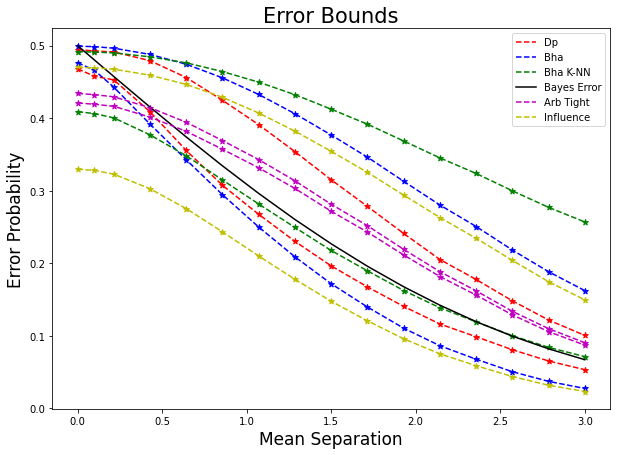

In [11]:
fs = 17

fig, ax = plt.subplots(figsize=(10, 7))

# Plot Dp
ax.plot(df["Dp_lower"], 'r--', label='Dp')
ax.plot(df["Dp_upper"], 'r--')
ax.scatter(df.index, df["Dp_lower"], color='r', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='r', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'b--', label='Bha')
ax.plot(df["Bha_upper"], 'b--')
ax.scatter(df.index, df["Bha_upper"], color='b', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='b', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(mean_sep, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'm--', label="Arb Tight")
ax.plot(df["tight_upper"], 'm--')
ax.scatter(df.index, df["tight_lower"], color='m', marker='*')
ax.scatter(df.index, df["tight_upper"], color='m', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'y--', label="Influence")
ax.plot(df["inf_upper"], 'y--')
ax.scatter(df.index, df["inf_lower"], color='y', marker='*')
ax.scatter(df.index, df["inf_upper"], color='y', marker='*')


ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

plt.show()


In [12]:
df = pd.DataFrame([obj() for obj in bound_obj_lst2], index = mean_sep)

# df

In [13]:

df

,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper
0.000000,0.469090,0.494827,0.497128,0.499894,0.348456,0.476445,0.360281,0.372298,0.495827,0.009593,0.096494
0.100000,0.460623,0.493040,0.494389,0.499775,0.347319,0.476077,0.359788,0.371794,0.494865,0.009490,0.096150
0.214286,0.454313,0.491455,0.481833,0.499061,0.344176,0.475052,0.357491,0.369444,0.490579,0.009410,0.095834
0.428571,0.414347,0.481588,0.413395,0.491842,0.331594,0.470714,0.348967,0.360712,0.474617,0.009714,0.096686
0.642857,0.370138,0.463598,0.353313,0.477586,0.312621,0.463447,0.334727,0.346114,0.449648,0.008927,0.093641
0.857143,0.326375,0.438473,0.299591,0.457791,0.289489,0.453410,0.317908,0.328852,0.418260,0.008643,0.092195
1.071429,0.287772,0.409037,0.254524,0.435234,0.264366,0.440800,0.296263,0.306599,0.385617,0.008650,0.091867
1.285714,0.252126,0.376388,0.213216,0.409261,0.238738,0.426137,0.274863,0.284571,0.352120,0.008310,0.090197
1.500000,0.217387,0.339720,0.174214,0.378977,0.210595,0.407516,0.248939,0.257854,0.317912,0.007825,0.087845
1.714286,0.186182,0.302630,0.140741,0.347401,0.183858,0.387146,0.221903,0.229946,0.286181,0.007684,0.086846


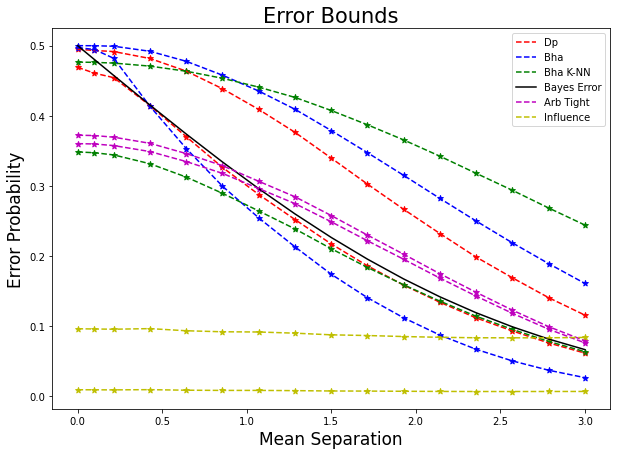

In [14]:
fs = 17

fig, ax = plt.subplots(figsize=(10, 7))

# Plot Dp
ax.plot(df["Dp_lower"], 'r--', label='Dp')
ax.plot(df["Dp_upper"], 'r--')
ax.scatter(df.index, df["Dp_lower"], color='r', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='r', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'b--', label='Bha')
ax.plot(df["Bha_upper"], 'b--')
ax.scatter(df.index, df["Bha_upper"], color='b', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='b', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(mean_sep, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'm--', label="Arb Tight")
ax.plot(df["tight_upper"], 'm--')
ax.scatter(df.index, df["tight_lower"], color='m', marker='*')
ax.scatter(df.index, df["tight_upper"], color='m', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'y--', label="Influence")
ax.plot(df["inf_upper"], 'y--')
ax.scatter(df.index, df["inf_lower"], color='y', marker='*')
ax.scatter(df.index, df["inf_upper"], color='y', marker='*')


ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

plt.show()
